<a href="https://colab.research.google.com/github/EnqiangYuan-hub/EthicsinAI_RefugeeDetermination/blob/main/Ethics_RSD_CaseStudy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Ethics in AI Decision-Making: A Refugee Status Determination Case Study

This workbook explores how automated systems can encode and amplify bias in high-stakes humanitarian decisions. You will examine a synthetic dataset modelled on real Refugee Status Determination (RSD) processes, trace how bias shows up across three distinct ethical issues, and write your own bias audit.



## Section 0: Pre-Exercise Questions

Take 5 minutes to go through the pre-exercise questions on the worksheet. Write your answers individually before discussing with your group. There are no right or wrong answers. We will revisit these questions at the end of the workbook.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

sns.set_theme(style="whitegrid", palette="muted")
np.random.seed(42)
print("Libraries loaded!")

Libraries loaded!


In [2]:
def viewDecisionDistribution(data, decision_col='final_decision'):
    counts = data[decision_col].value_counts()
    plt.figure()
    plt.pie(counts, labels=counts.index, autopct='%1.1f%%',
            startangle=90, colors=['#66c2a5', '#fc8d62'])
    plt.title(f'Distribution of: {decision_col}')
    plt.tight_layout(); plt.show()

def viewApprovalRateBy(data, groupby_col, decision_col='final_decision'):
    rate = (data.groupby(groupby_col)[decision_col]
            .apply(lambda x: (x == 'approve').mean())
            .sort_values().reset_index())
    rate.columns = [groupby_col, 'approval_rate']
    plt.figure(figsize=(8, 4))
    plt.barh(rate[groupby_col], rate['approval_rate'], color='#66c2a5', edgecolor='white')
    plt.axvline(rate['approval_rate'].mean(), color='#fc8d62',
                linestyle='--', linewidth=1.5, label='Overall average')
    plt.xlabel('Approval Rate'); plt.title(f'Approval Rate by {groupby_col}')
    plt.xlim(0, 1); plt.legend(); plt.tight_layout(); plt.show()

def viewScoreDistribution(data, score_col, hue_col=None):
    plt.figure(figsize=(8, 4))
    if hue_col:
        for val in data[hue_col].unique():
            sns.kdeplot(data[data[hue_col] == val][score_col],
                        label=str(val), fill=True, alpha=0.4)
        plt.legend(title=hue_col)
    else:
        sns.histplot(data[score_col], bins=30, kde=True, color='#66c2a5')
    plt.xlabel(score_col); plt.ylabel('Density')
    plt.title(f'{score_col}' + (f' by {hue_col}' if hue_col else ''))
    plt.tight_layout(); plt.show()

def viewScoreByDecision(data, score_col, decision_col='final_decision'):
    plt.figure(figsize=(6, 4))
    sns.boxplot(data=data, x=decision_col, y=score_col,
                palette={'approve': '#66c2a5', 'deny': '#fc8d62'})
    plt.title(f'{score_col} by {decision_col}')
    plt.tight_layout(); plt.show()

def viewCategoricalBreakdown(data, category_col, hue_col='final_decision'):
    plt.figure(figsize=(9, 4))
    palette = {'approve': '#66c2a5', 'deny': '#fc8d62',
               'Male': '#66c2a5', 'Female': '#fc8d62', 'Non-binary': '#8da0cb',
               True: '#fc8d62', False: '#66c2a5'}
    sns.countplot(data=data, x=category_col, hue=hue_col, palette=palette,
                  order=data[category_col].value_counts().index)
    plt.xticks(rotation=45, ha='right')
    plt.title(f'{category_col} by {hue_col}')
    plt.tight_layout(); plt.show()

def plotFeatureImportance(model, X_train):
    importances = pd.Series(model.feature_importances_,
                            index=X_train.columns).sort_values()
    plt.figure(figsize=(7, 5))
    importances.plot(kind='barh', color='#66c2a5', edgecolor='white')
    plt.xlabel('Importance'); plt.title('Feature Importance — Random Forest')
    plt.tight_layout(); plt.show()

print("Helper functions loaded!")

Helper functions loaded!



## Section 2: Load the Data

Upload `RefugeeProfile.csv` to your Google Drive, then run the cell below.
(Detailed instructions on loading the data set can be foun on the worksheet)


In [5]:
from google.colab import files
uploaded = files.upload()
print(f"Shape: {df.shape}")
df.head(10)

Saving RefugeeProfile.csv to RefugeeProfile.csv
Shape: (500, 21)


,id,country_of_origin,gender,age,education_level,language_proficiency,family_size,prior_camp_years,persecution_type,state_protection_score,...,reported_trauma,credibility_score,risk_score,AI_decision,human_reviewed,human_override,final_decision,processing_time_days,appealed,appeal_outcome
0,1,Iraq,Male,23,Tertiary,Intermediate,3,3,detention,0.228795,...,True,0.671384,0.662176,deny,False,False,deny,76,False,NaN
1,2,Myanmar,Male,23,Secondary,Fluent,5,9,sexual_violence,0.454968,...,True,0.908833,0.867587,approve,False,False,approve,45,False,NaN
2,3,Eritrea,Female,20,Secondary,Basic,3,5,discrimination,0.517138,...,True,0.528028,0.728535,deny,True,True,approve,126,False,NaN
3,4,Iraq,Male,24,Secondary,Basic,3,9,sexual_violence,0.315926,...,False,0.636441,0.761609,approve,True,True,deny,149,False,NaN
4,5,Sudan,Male,25,Primary,Advanced,4,2,sexual_violence,0.251365,...,True,0.778331,0.864208,approve,False,False,approve,72,False,NaN
5,6,Somalia,Female,59,Primary,Intermediate,2,1,detention,0.420439,...,True,0.571552,0.869276,approve,False,False,approve,37,False,NaN
6,7,Eritrea,Female,32,Primary,Basic,4,5,threats,0.050000,...,False,0.870478,0.730372,approve,False,False,approve,32,False,NaN
7,8,Eritrea,Female,64,Primary,Basic,4,4,discrimination,0.141723,...,True,0.280444,0.776702,deny,False,False,deny,41,True,overturned
8,9,Iraq,Female,46,Secondary,Basic,1,9,detention,0.050000,...,False,0.459878,0.819970,deny,False,False,deny,113,True,overturned
9,10,Afghanistan,Male,50,Primary,Advanced,4,4,sexual_violence,0.140145,...,True,0.712094,0.996784,approve,False,False,approve,45,False,NaN


### Who are these people? The demographic variables

The dataset has **500 applicants** and **21 variables**. These are the raw data collected from the applicants that determine how they will later be assessed by the algorithm:

| Variable | Description |
|---|---|
| `id` | Unique applicant ID |
| `country_of_origin` | Country they fled: Afghanistan, Eritrea, Iraq, Myanmar, Somalia, Sudan |
| `gender` | Male, Female, Non-binary |
| `age` | Age in years (18–64) |
| `education_level` | Highest education: Primary, Secondary, Tertiary |
| `language_proficiency` | Proficiency in the processing country's language: Basic, Intermediate, Advanced, Fluent |
| `family_size` | Number of people in their household (1–6) |
| `prior_camp_years` | Years previously spent in a refugee camp (0–9) |
| `persecution_type` | What they claim to have fled: `detention`, `discrimination`, `sexual_violence`, `threats`, `violence` |
| `state_protection_score` | Estimated ability of the home state to protect the applicant (0–1); lower = less protection available |
| `internal_relocation_possible` | Whether the applicant could have safely relocated within their home country instead of fleeing |
| `reported_trauma` | Whether the applicant disclosed psychological trauma during their interview |

In [6]:
# Get a statistical overview of numeric variables
df.describe().round(2)

,id,age,family_size,prior_camp_years,state_protection_score,credibility_score,risk_score,processing_time_days
count,500.00,500.00,500.00,500.00,500.00,500.00,500.00,500.00
mean,250.50,41.91,3.53,4.41,0.31,0.62,0.81,79.88
std,144.48,13.57,1.71,2.84,0.14,0.18,0.12,29.93
min,1.00,18.00,1.00,0.00,0.05,0.00,0.47,30.00
25%,125.75,30.00,2.00,2.00,0.21,0.50,0.73,54.00
50%,250.50,42.00,4.00,4.00,0.32,0.63,0.81,81.00
75%,375.25,54.00,5.00,7.00,0.41,0.74,0.91,102.00
max,500.00,64.00,6.00,9.00,0.68,1.00,1.00,175.00


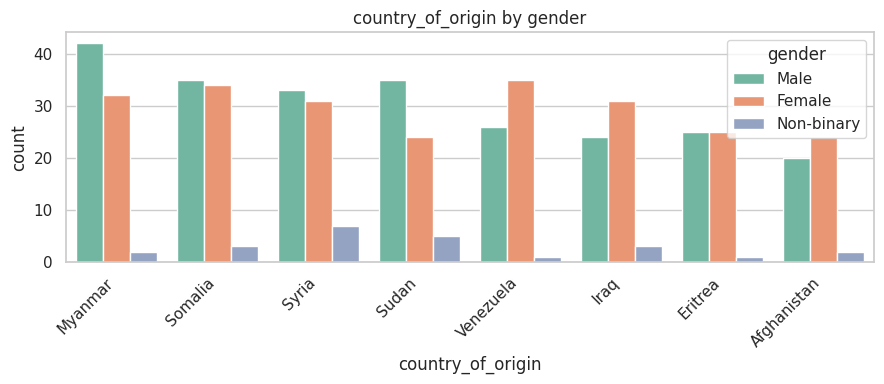

In [7]:
# Who is in this dataset? Let's explore the population.
viewCategoricalBreakdown(df, 'country_of_origin', hue_col='gender')

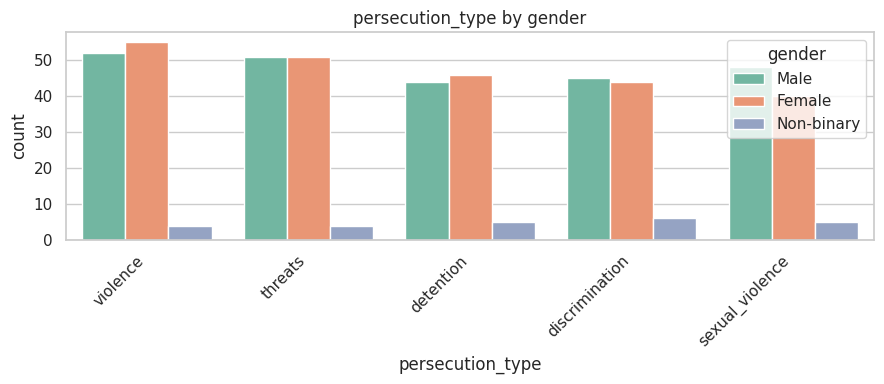

In [ ]:
viewCategoricalBreakdown(df, 'persecution_type', hue_col='gender')

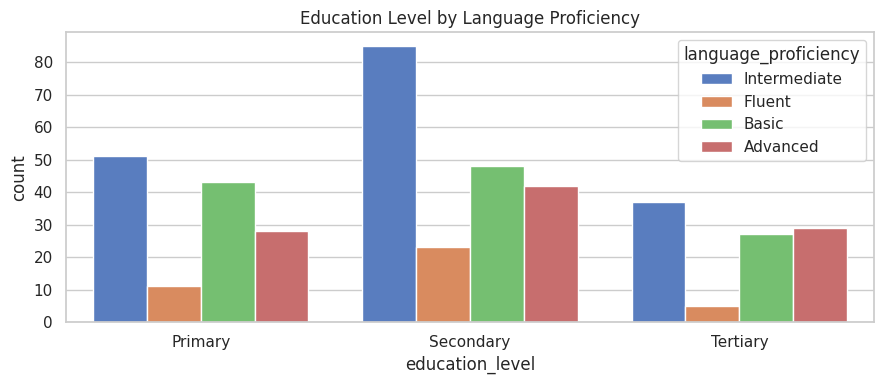

In [8]:
plt.figure(figsize=(9, 4))
sns.countplot(data=df, x='education_level', hue='language_proficiency',
              order=['Primary', 'Secondary', 'Tertiary'])
plt.title('Education Level by Language Proficiency')
plt.tight_layout()
plt.show()

**Discussion:**

- Which groups do you expect to face the most difficulty in a formal legal process like this? What assumptions are you making?
- Notice that language proficiency and education level are not evenly distributed across countries and genders. Why might that matter when an AI is making decisions about people?
- What information is missing from this dataset that you think would be important for a fair decision?


## Section 3. How Does the AI Decide?

Now let's understand the AI scoring system.

### **Overall Flow**

                                 Applicant Data
                                       ↓
                   ┌───────────────────────────────────────┐
                   │                                       │
                   │            credibility_score          │
                   │     (language, edu, trauma penalty)   │
                   │                                       │
                   │                risk_score             │
                   │       (country, gender, persecution)  │
                   └───────────────────────────────────────┘
                                       ↓
                               Composite Score S
                                       ↓
                                  AI Decision
                                       ↓
                                Human Review
                                       ↓
                                Final Decision
                                       ↓
    If Denied → Appeal (30% file) → overturned (40%) / upheld (60%)


**There are two scores that drive every decision, plus the final decision variable:**

##### **Credibility Score**

$$C = \text{Base} \sim N(0.65,\ 0.15) + L_{\text{effect}} + E_{\text{effect}} + T_{\text{penalty}}$$

| Component | Values |
|---|---|
| **Language effect** $L$ | None = −0.20 · Basic = −0.10 · Intermediate = 0 · Advanced = +0.05 · Fluent = +0.10 |
| **Education effect** $E$ | None = −0.10 · Primary = 0 · Secondary = +0.05 · Tertiary = +0.10 |
| **Trauma penalty** $T$ | −0.08 if `reported_trauma = True`, else 0 |

Final score is clipped to [0, 1].

##### **Risk Score**

$$R = \text{Country base} + G_{\text{effect}} + P_{\text{effect}} + \varepsilon, \quad \varepsilon \sim N(0,\ 0.05)$$

| Component | Values |
|---|---|
| **Country base** | Ranges from 0.55 (Venezuela) to 0.85 (Syria) |
| **Gender effect** $G$ | Male = 0 · Female = +0.08 · Non-binary = +0.06 |
| **Persecution effect** $P$ | sexual\_violence = +0.15 · violence = +0.10 · detention = +0.05 · threats = 0 · discrimination = −0.05 |

Final score is clipped to [0, 1].      


### **The AI decision formula**

The AI combines the two scores using a weighted formula:

> **AI composite score S = 0.6 × risk_score + 0.4 × credibility_score**

If the AI score is **≥ 0.75**, the AI recommends `approve`. Below that, it recommends `deny`.

## Meet Sophia and Omar

Let's look at two specific cases. Both are real applicants in the dataset — Sophia is applicant ID 316, Omar is applicant ID 241.

### **Sophia** (ID 316)

*   28-year-old woman
*   from Somalia
*   fled after being subjected to sexual violence
*   has a secondary school education and speaks Basic English
*   did not relocate internally before fleeing
*   disclosed psychological trauma during her interview

| Variable | Value |
|---|---|
| `country_of_origin` | Somalia |
| `gender` | Female |
| `age` | 28 |
| `education_level` | Secondary |
| `language_proficiency` | Basic |
| `family_size` | 1 |
| `prior_camp_years` | 6 |
| `persecution_type` | sexual_violence |
| `state_protection_score` | 0.261 |
| `internal_relocation_possible` | False |
| `reported_trauma` | True |
| `credibility_score` | 0.359 |
| `risk_score` | 0.924 |
| **AI score** | 0.6 × 0.924 + 0.4 × 0.359 = **0.698** |
| **AI decision** | 0.698 < 0.75 → **DENY** |
| `human_reviewed` | False |
| `human_override` | False |
| `final_decision` | **deny** |
| `processing_time_days` | 112 |
| `appealed` | False |

### **Omar** (ID 241)

*   47-year-old man
*   from Afghanistan
*   fled after threats from militia members following his refusal to cooperate with them
*   has a secondary school education and speaks Fluent English
*   did not relocate internally before fleeing
*   did not disclose psychological trauma during his interview

| Variable | Value |
|---|---|
| `country_of_origin` | Afghanistan |
| `gender` | Male |
| `age` | 47 |
| `education_level` | Secondary |
| `language_proficiency` | Fluent |
| `family_size` | 5 |
| `prior_camp_years` | 7 |
| `persecution_type` | threats |
| `state_protection_score` | 0.336 |
| `internal_relocation_possible` | False |
| `reported_trauma` | False |
| `credibility_score` | 0.738 |
| `risk_score` | 0.783 |
| **AI score** | 0.6 × 0.783 + 0.4 × 0.738 = **0.765** |
| **AI decision** | 0.765 ≥ 0.75 → **APPROVE** |
| `human_reviewed` | False |
| `human_override` | False |
| `final_decision` | **approve** |
| `processing_time_days` | 105 |
| `appealed` | False |

**Discussion:**
If you were them, what would you want taken out or included in the dataset to make a stronger case for your refugee status?

Keep both Sophia and Omar in mind as you work through the rest of this workbook.


## Section 4. Ethical Issue 1: The Credibility Trap

The credibility score is supposed to measure whether an applicant's story is coherent and plausible. But coherence in a legal interview is shaped by many things besides truthfulness, like trauma, education, language fluency, and cultural norms around disclosure of sensitive events.

Look back at how the credibility score is constructed: it is mechanically increased by language proficiency and education level, and mechanically decreased by reporting trauma.

The question this section asks is: does the credibility score measure what it claims to measure?

Let's look at the data for both Sophia and Omar, and for the broader population.

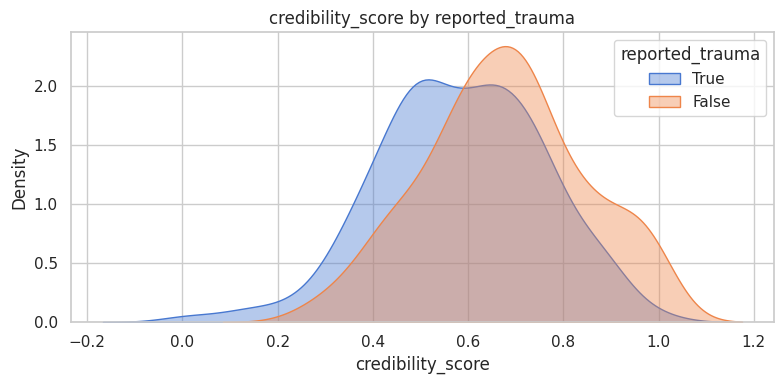

Average credibility score:
reported_trauma
False    0.676
True     0.584
Name: credibility_score, dtype: float64


In [9]:
# Do trauma survivors get lower credibility scores?
viewScoreDistribution(df, 'credibility_score', hue_col='reported_trauma')
print("Average credibility score:")
print(df.groupby('reported_trauma')['credibility_score'].mean().round(3))

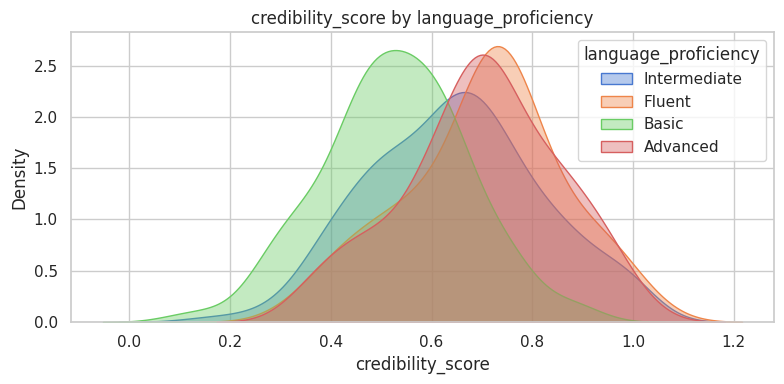

Average credibility score by language proficiency:
language_proficiency
Basic           0.527
Intermediate    0.646
Advanced        0.697
Fluent          0.701
Name: credibility_score, dtype: float64


In [10]:
# Does language proficiency predict credibility?
viewScoreDistribution(df, 'credibility_score', hue_col='language_proficiency')
print("Average credibility score by language proficiency:")
print(df.groupby('language_proficiency')['credibility_score'].mean().round(3).sort_values())

In [11]:
# Does education level predict credibility?
print("Average credibility score by education level:")
print(df.groupby('education_level')['credibility_score'].mean().round(3).sort_values())

Average credibility score by education level:
education_level
Primary      0.600
Secondary    0.632
Tertiary     0.685
Name: credibility_score, dtype: float64


In [12]:
# Among trauma survivors, does persecution type matter?
print("Average credibility score by persecution type (trauma reporters only):")
trauma = df[df['reported_trauma'] == True]
print(trauma.groupby('persecution_type')['credibility_score'].mean().round(3).sort_values())

Average credibility score by persecution type (trauma reporters only):
persecution_type
discrimination     0.530
sexual_violence    0.587
detention          0.589
threats            0.590
violence           0.622
Name: credibility_score, dtype: float64


In [13]:
# What is the final decision rate for trauma survivors vs non-survivors?
print("Approval rates:")
print(df.groupby('reported_trauma')['final_decision']
      .apply(lambda x: (x == 'approve').mean()).round(3))

Approval rates:
reported_trauma
False    0.678
True     0.590
Name: final_decision, dtype: float64


**Discussion:**

1. The data shows that reporting trauma is associated with a lower credibility score. Sophia reported trauma and received a credibility score of 0.54. Omar did not report trauma and received 0.71. What does that pattern tell you about what the credibility score is actually measuring?

2. Language proficiency and education predict credibility scores. Should someone's ability to articulate their experience fluently in a second language determine whether they are believed?



## Section 5. Ethical Issue 2: Group Disparities

The credibility problem does not affect everyone equally. Because credibility is entangled with language and education, and because language and education are unevenly distributed across countries, genders, and persecution types, individual-level bias in scoring translates into systematic group-level disparities in outcomes.

This section looks at who is being approved and who is being denied, and asks whether those patterns demonstrate systematic bias.

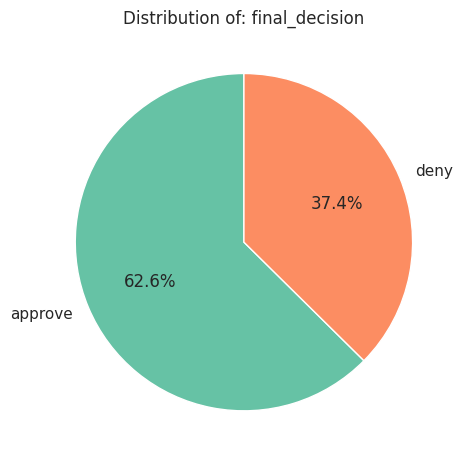

Overall approval rate: 62.6%


In [14]:
# Overall approval rate
viewDecisionDistribution(df)
print(f"Overall approval rate: {(df['final_decision']=='approve').mean():.1%}")

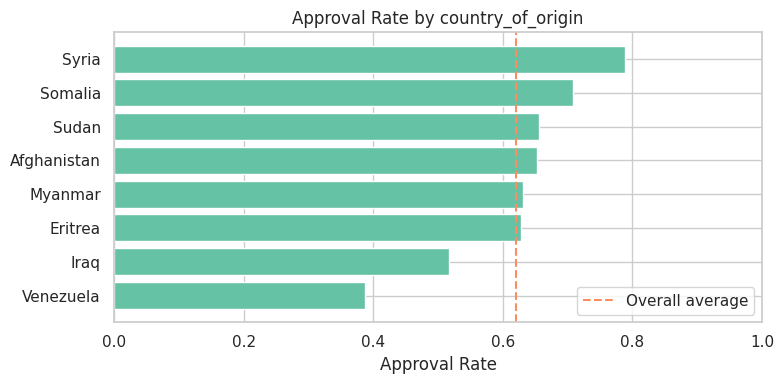

In [15]:
# Approval rates by country of origin
viewApprovalRateBy(df, 'country_of_origin')

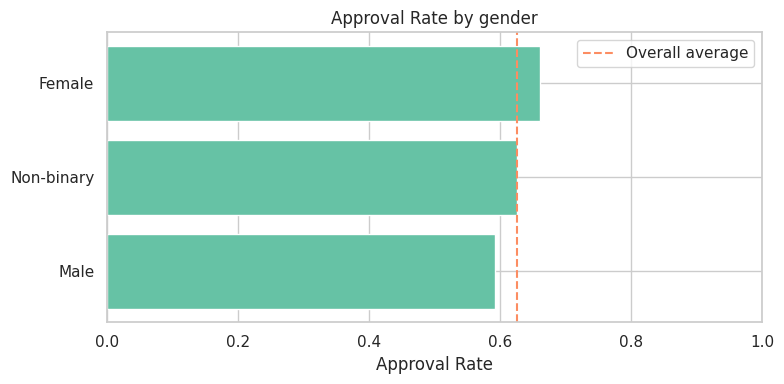

In [16]:
# Approval rates by gender
viewApprovalRateBy(df, 'gender')

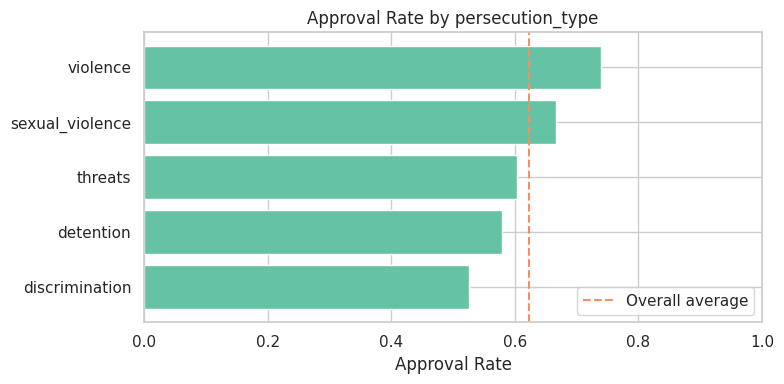

In [17]:
# Approval rates by persecution type
viewApprovalRateBy(df, 'persecution_type')

In [ ]:
# Now separate risk score and credibility score by group
# to understand *why* certain groups have lower approval rates
print("Average scores by gender:")
print(df.groupby('gender')[['risk_score', 'credibility_score', 'final_decision']].agg({
    'risk_score': 'mean',
    'credibility_score': 'mean',
    'final_decision': lambda x: (x == 'approve').mean()
}).round(3).rename(columns={'final_decision': 'approval_rate'}))

Average scores by gender:
            risk_score  credibility_score  approval_rate
gender                                                  
Female           0.837              0.625          0.661
Male             0.779              0.615          0.592
Non-binary       0.854              0.659          0.625


In [ ]:
# Same breakdown by education level — a proxy variable
print("Average scores by education level:")
print(df.groupby('education_level')[['risk_score', 'credibility_score', 'final_decision']].agg({
    'risk_score': 'mean',
    'credibility_score': 'mean',
    'final_decision': lambda x: (x == 'approve').mean()
}).round(3).rename(columns={'final_decision': 'approval_rate'}))

Average scores by education level:
                 risk_score  credibility_score  approval_rate
education_level                                              
Primary               0.821              0.600          0.597
Secondary             0.811              0.632          0.652
Tertiary              0.794              0.685          0.728


In [ ]:
# Try your own: change group_col to explore different cuts
group_col = 'country_of_origin'  # try imputing: 'language_proficiency', 'persecution_type', 'gender' instead of 'country_of_origin'

print(f"Average scores by {group_col}:")
print(df.groupby(group_col)[['risk_score', 'credibility_score', 'final_decision']].agg({
    'risk_score': 'mean',
    'credibility_score': 'mean',
    'final_decision': lambda x: (x == 'approve').mean()
}).round(3).rename(columns={'final_decision': 'approval_rate'}).sort_values('approval_rate'))

Average scores by country_of_origin:
                   risk_score  credibility_score  approval_rate
country_of_origin                                              
Venezuela               0.646              0.651          0.387
Iraq                    0.748              0.594          0.517
Eritrea                 0.778              0.627          0.627
Myanmar                 0.789              0.635          0.632
Afghanistan             0.895              0.590          0.652
Sudan                   0.817              0.628          0.656
Somalia                 0.869              0.610          0.708
Syria                   0.928              0.628          0.789


**Sophia and Omar in the group picture.**

Sophia's profile (female, sexual_violence, trauma reported, Basic English, Primary education) sits at the intersection of several disadvantaged groups in the data.   
Omar's profile (male, threats, no trauma, Intermediate English, Secondary education) sits closer to the groups with higher approval rates.

What can this imply about how the system treats specific traits?


In [18]:
# Pull Sophia and Omar directly from the dataset
sophia = df[df['id'] == 316].iloc[0]
omar   = df[df['id'] == 241].iloc[0]

print("Sophia (ID 316):")
print(f"  risk_score:        {sophia['risk_score']:.3f}")
print(f"  credibility_score: {sophia['credibility_score']:.3f}")
print(f"  final_decision:    {sophia['final_decision']}")
print()
print("Omar (ID 241):")
print(f"  risk_score:        {omar['risk_score']:.3f}")
print(f"  credibility_score: {omar['credibility_score']:.3f}")
print(f"  final_decision:    {omar['final_decision']}")
print()

# How do their groups compare broadly?
sophia_like = df[
    (df['gender'] == 'Female') &
    (df['persecution_type'] == 'sexual_violence') &
    (df['reported_trauma'] == True)
]
omar_like = df[
    (df['gender'] == 'Male') &
    (df['persecution_type'] == 'threats') &
    (df['reported_trauma'] == False)
]

print(f"Cases matching Sophia's profile (female, sexual_violence, trauma reported): {len(sophia_like)}")
print(f"  Average risk score:        {sophia_like['risk_score'].mean():.3f}  (all: {df['risk_score'].mean():.3f})")
print(f"  Average credibility score: {sophia_like['credibility_score'].mean():.3f}  (all: {df['credibility_score'].mean():.3f})")
print(f"  Approval rate:             {(sophia_like['final_decision']=='approve').mean():.1%}  (all: {(df['final_decision']=='approve').mean():.1%})")
print()
print(f"Cases matching Omar's profile (male, threats, no trauma reported): {len(omar_like)}")
print(f"  Average risk score:        {omar_like['risk_score'].mean():.3f}  (all: {df['risk_score'].mean():.3f})")
print(f"  Average credibility score: {omar_like['credibility_score'].mean():.3f}  (all: {df['credibility_score'].mean():.3f})")
print(f"  Approval rate:             {(omar_like['final_decision']=='approve').mean():.1%}  (all: {(df['final_decision']=='approve').mean():.1%})")


Sophia (ID 316):
  risk_score:        0.924
  credibility_score: 0.359
  final_decision:    deny

Omar (ID 241):
  risk_score:        0.783
  credibility_score: 0.738
  final_decision:    approve

Cases matching Sophia's profile (female, sexual_violence, trauma reported): 29
  Average risk score:        0.949  (all: 0.810)
  Average credibility score: 0.530  (all: 0.622)
  Approval rate:             55.2%  (all: 62.6%)

Cases matching Omar's profile (male, threats, no trauma reported): 28
  Average risk score:        0.734  (all: 0.810)
  Average credibility score: 0.636  (all: 0.622)
  Approval rate:             57.1%  (all: 62.6%)


**Discussion:**

1. Look at the approval rates by persecution type. Cases involving sexual violence have some of the lowest approval rates. What might explain this?

2. Is there a difference between a disparity that is caused by the algorithm and one that reflects real-world inequality in who faces what kinds of danger? Does that distinction matter ethically?

3. Think about Sophia and Omar as representatives of their groups. What information would you want collected at a population level to determine whether the system is treating people fairly?

## Section 6. Ethical Issue 3: Human Judgment vs. Algorithmic Decision-Making

Remember, after the AI makes a decision, there is a following step of human review, which can override the AI decision and will influence the final decision.

There is a fundamental tension in this system that the data alone cannot fully capture: human caseworkers and the AI have different approaches when it comes to certain factors of the cases.

A caseworker experienced with refugee interviews is likely to know that trauma fragments memory, and tend to have more sympathy towards cases with severe trauma.

In this model, the AI does the opposite. Inconsistency lowers the credibility score. Calm coherence raises it. Reporting trauma reduces the score by a fixed penalty.

This section asks: when humans do review cases, do they push back against the AI's logic? And what does it mean that most cases are never reviewed at all?


### Human Review

In [ ]:
print(f"Cases reviewed by a human:     {df['human_reviewed'].sum()} ({df['human_reviewed'].mean():.1%})")
print(f"Cases where human overrode AI: {df['human_override'].sum()} ({df['human_override'].mean():.1%})")
print(f"Of reviewed cases, overridden: {df[df['human_reviewed']]['human_override'].mean():.1%}")

Cases reviewed by a human:     50 (10.0%)
Cases where human overrode AI: 23 (4.6%)
Of reviewed cases, overridden: 46.0%


In [ ]:
# When humans override, which direction do they go?
overridden = df[df['human_override'] == True]
print("AI decision → final decision, among overridden cases:")
print(overridden[['AI_decision', 'final_decision']].value_counts())

AI decision → final decision, among overridden cases:
AI_decision  final_decision
approve      deny              13
deny         approve           10
Name: count, dtype: int64


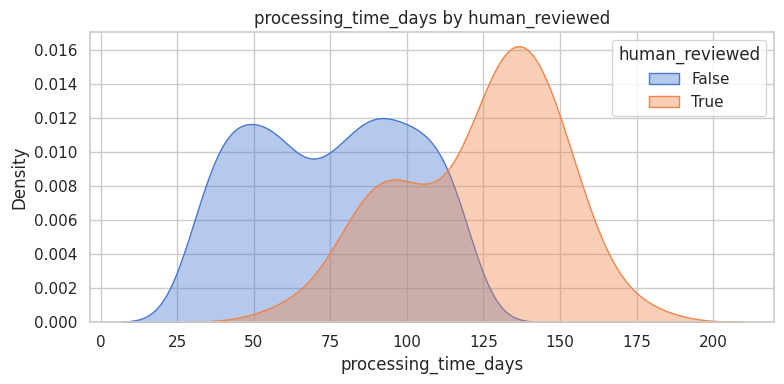

Average processing time (days):
human_reviewed
False     75.0
True     123.5
Name: processing_time_days, dtype: float64


In [ ]:
# Does human review take longer?
viewScoreDistribution(df, 'processing_time_days', hue_col='human_reviewed')
print("Average processing time (days):")
print(df.groupby('human_reviewed')['processing_time_days'].mean().round(1))

The override rate among reviewed cases is around 50%. That means when a human looked at what the AI decided, they disagreed roughly half the time. For the 90% of cases that were never reviewed, no one checked whether the AI was right.

Omar was approved without review. Sophia was denied without review. In both cases, the AI's logic went unchallenged.

**Discussion:**   
If humans override the AI in roughly half of reviewed cases, what does that imply about the AI's accuracy across all cases?



### The Appeals Process

Cases that appealed: 53 (28.3% of denied cases)


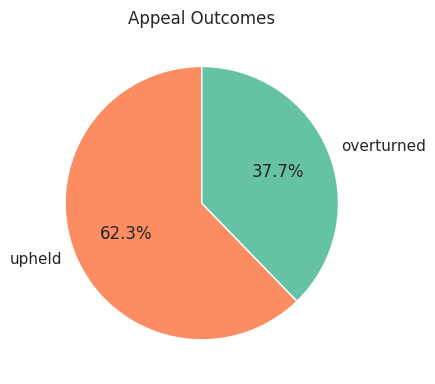

In [19]:
denied = df[df['final_decision'] == 'deny']
print(f"Cases that appealed: {df['appealed'].sum()} ({denied['appealed'].mean():.1%} of denied cases)")

appeal_counts = df[df['appealed'] == True]['appeal_outcome'].value_counts()
plt.figure(figsize=(5, 4))
plt.pie(appeal_counts, labels=appeal_counts.index, autopct='%1.1f%%',
        colors=['#fc8d62', '#66c2a5'], startangle=90)
plt.title('Appeal Outcomes')
plt.tight_layout(); plt.show()

In [20]:
# Does internal relocation possibility affect who appeals and what happens?
print("Appeal rate among denied cases, by internal_relocation_possible:")
print(df[df['final_decision']=='deny'].groupby('internal_relocation_possible')['appealed'].mean().round(3))
print()
print("Overturn rate among appealed cases, by internal_relocation_possible:")
appeals = df[df['appealed'] == True]
print(appeals.groupby('internal_relocation_possible')['appeal_outcome']
      .apply(lambda x: (x == 'overturned').mean()).round(3))


Appeal rate among denied cases, by internal_relocation_possible:
internal_relocation_possible
False    0.278
True     0.292
Name: appealed, dtype: float64

Overturn rate among appealed cases, by internal_relocation_possible:
internal_relocation_possible
False    0.375
True     0.381
Name: appeal_outcome, dtype: float64


In [22]:
# Who is most likely to be denied AND not appeal?
# These are the most unprotected cases
unprotected = df[
    (df['final_decision'] == 'deny') &
    (df['appealed'] == False) &
    (df['human_reviewed'] == False)
]
print(f"Denied, no human review, no appeal: {len(unprotected)} cases ({len(unprotected)/len(df):.1%} of all cases)")
print(f"  Reported trauma:                {unprotected['reported_trauma'].mean():.1%}")
print(f"  Internal relocation possible:   {unprotected['internal_relocation_possible'].mean():.1%}")
print(f"  Average credibility:            {unprotected['credibility_score'].mean():.3f}")
print(f"  Average risk:                   {unprotected['risk_score'].mean():.3f}")
print(f"  Gender breakdown:")
print(unprotected['gender'].value_counts())


Denied, no human review, no appeal: 123 cases (24.6% of all cases)
  Reported trauma:                64.2%
  Internal relocation possible:   37.4%
  Average credibility:            0.444
  Average risk:                   0.771
  Gender breakdown:
gender
Male          64
Female        53
Non-binary     6
Name: count, dtype: int64


**Discussion:**

1. About 40% of appeals are overturned, but only around 30% of denied applicants appeal. What does that suggest about the system's real error rate?

3. The appeals process effectively functions as a second layer of human review, but only for those who can access it. Is a rights mechanism that is systematically inaccessible to the most vulnerable still a rights mechanism?


## Section 7 — Design Your Own Bias Audit

In the real world, after an AI system has made thousands of decisions, auditors look back and ask: did the system treat certain people unfairly in ways that cannot be justified by the strength of their case?

Here, you have the opportunity of designing your own bias audit, and explore to what extent is the AI system biased, and how we can measure it.

We have given you three pre-written flags below to get you started. For each one, you can adjust the thresholds. Then there is a fourth flag that is yours to define.


In [24]:
def my_bias_audit(row):
    """
    Returns 'none', 'moderate', or 'severe' for each applicant row.

    FLAG A — The Sophia problem:
    High danger, denied because of low credibility.
    Adjust the thresholds below.
    """
    risk_threshold_A    = 0.80   # ← try changing this (0 to 1)
    credibility_cap_A   = 0.60   # ← try changing this (0 to 1)

    if (row['risk_score'] > risk_threshold_A and
        row['credibility_score'] < credibility_cap_A and
        row['final_decision'] == 'deny'):
        return 'severe'

    """
    FLAG B — Trauma penalty:
    Reported trauma, but denied with a credibility score below a threshold.
    """
    credibility_cap_B = 0.55   # ← try changing this

    if (row['reported_trauma'] == True and
        row['credibility_score'] < credibility_cap_B and
        row['final_decision'] == 'deny'):
        return 'moderate'

    """
    FLAG C — No safety net:
    Denied, no human ever reviewed it, and internal relocation was not possible.
    These cases had no protection against an AI error and nowhere else to go.
    """
    if (row['final_decision'] == 'deny' and
        row['human_reviewed'] == False and
        row['internal_relocation_possible'] == False):
        return 'moderate'

    """
    FLAG D — Your own flag.
    Think about what else might constitute unfair treatment.
    Some ideas:
    - Cases where the AI and the formula don't quite match
    - Approval of low-risk cases (is the bar consistent?)
    - Patterns by country or persecution type
    Remove the 'pass' and replace with your own logic.
    """
    # YOUR CODE HERE
    pass

    return 'none'

df['my_bias_flag'] = df.apply(my_bias_audit, axis=1)
print("Your bias flag distribution:")
print(df['my_bias_flag'].value_counts())


Your bias flag distribution:
my_bias_flag
none        348
moderate     82
severe       70
Name: count, dtype: int64


Take a look at the breakdown of your flagged cases:

In [25]:
flagged = df[df['my_bias_flag'] != 'none']
print(f"Total flagged: {len(flagged)} ({len(flagged)/len(df):.1%} of all cases)")

if len(flagged) > 0:
    print(f"\nGender breakdown:")
    print(flagged['gender'].value_counts())
    print(f"\nCountry breakdown:")
    print(flagged['country_of_origin'].value_counts())
    print(f"\nPersecution type:")
    print(flagged['persecution_type'].value_counts())
    print(f"\nAvg credibility — flagged: {flagged['credibility_score'].mean():.3f}  |  all: {df['credibility_score'].mean():.3f}")
    print(f"Avg risk score  — flagged: {flagged['risk_score'].mean():.3f}  |  all: {df['risk_score'].mean():.3f}")

Total flagged: 152 (30.4% of all cases)

Gender breakdown:
gender
Male          77
Female        69
Non-binary     6
Name: count, dtype: int64

Country breakdown:
country_of_origin
Venezuela      27
Iraq           23
Myanmar        21
Somalia        19
Eritrea        18
Sudan          17
Afghanistan    14
Syria          13
Name: count, dtype: int64

Persecution type:
persecution_type
discrimination     34
threats            34
detention          32
sexual_violence    29
violence           23
Name: count, dtype: int64

Avg credibility — flagged: 0.442  |  all: 0.622
Avg risk score  — flagged: 0.777  |  all: 0.810


In [26]:
# Breakdown by flag severity
for severity in ['severe', 'moderate']:
    subset = df[df['my_bias_flag'] == severity]
    if len(subset) > 0:
        print(f"\n--- {severity.upper()} flags ({len(subset)} cases) ---")
        print(f"  Approval rate:       {(subset['final_decision']=='approve').mean():.1%}")
        print(f"  Reported trauma:     {subset['reported_trauma'].mean():.1%}")
        print(f"  Avg risk score:      {subset['risk_score'].mean():.3f}")
        print(f"  Avg credibility:     {subset['credibility_score'].mean():.3f}")


--- SEVERE flags (70 cases) ---
  Approval rate:       0.0%
  Reported trauma:     74.3%
  Avg risk score:      0.896
  Avg credibility:     0.400

--- MODERATE flags (82 cases) ---
  Approval rate:       0.0%
  Reported trauma:     67.1%
  Avg risk score:      0.674
  Avg credibility:     0.478


**Discussion:**

1. Compare your flagged population with a classmate's. Did you flag different cases? If so, whose definition of bias is more defensible?

2. A bias audit is only as good as the values of the person who wrote it. Could someone write a bias audit that concealed bias by defining it narrowly? What would that look like?



## Section 8. Can We Fix The System?

Let's train a new model to predict `final_decision` and examine which features it relies on. Then we'll try removing features that we suspect are biased — and see whether that actually helps the groups who were disadvantaged.

In [27]:
features = df.drop(columns=['id', 'final_decision', 'AI_decision',
                              'human_reviewed', 'human_override',
                              'appealed', 'appeal_outcome', 'my_bias_flag'])
targets = (df['final_decision'] == 'approve').astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    features, targets, test_size=0.3, random_state=42)
X_train_dum = pd.get_dummies(X_train, drop_first=True)
X_test_dum  = pd.get_dummies(X_test, drop_first=True).reindex(
    columns=X_train_dum.columns, fill_value=0)

baseline_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
baseline_model.fit(X_train_dum, y_train)
y_pred = baseline_model.predict(X_test_dum)
print(f"Baseline model accuracy: {accuracy_score(y_test, y_pred):.3f}")


Baseline model accuracy: 0.913


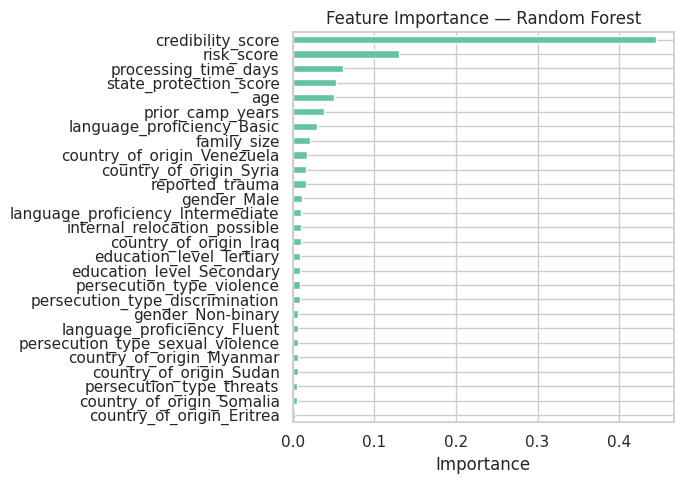

In [28]:
plotFeatureImportance(baseline_model, X_train_dum)

The most important features might be proxies for sensitive attributes. `credibility_score` encodes language and education effects. `country_of_origin` captures the country base rates from the risk score formula.

Your turn: add features to `featuresToDrop` below and retrain. Then check whether it actually improves outcomes for groups like Sophia's — not just overall accuracy.


Accuracy with dropped features: 0.913
Baseline accuracy:              0.913


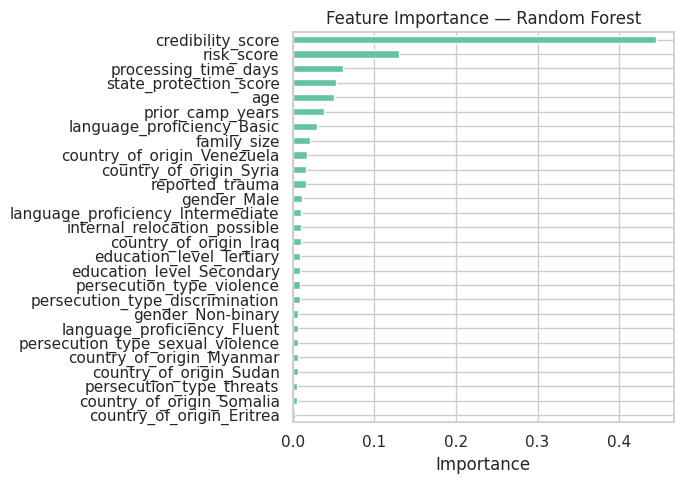

In [29]:
# Add column names here to exclude them from training
# e.g. featuresToDrop = ['credibility_score', 'country_of_origin', 'language_proficiency']
featuresToDrop = []

# --- don't modify below this line ---
features_dropped = df.drop(columns=['id', 'final_decision', 'AI_decision',
                                     'human_reviewed', 'human_override',
                                     'appealed', 'appeal_outcome',
                                     'my_bias_flag'] + featuresToDrop)

X_tr, X_te, y_tr, y_te = train_test_split(features_dropped, targets, test_size=0.3, random_state=42)
X_tr_d = pd.get_dummies(X_tr, drop_first=True)
X_te_d = pd.get_dummies(X_te, drop_first=True).reindex(columns=X_tr_d.columns, fill_value=0)

new_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
new_model.fit(X_tr_d, y_tr)
y_pred_new = new_model.predict(X_te_d)

print(f"Accuracy with dropped features: {accuracy_score(y_te, y_pred_new):.3f}")
print(f"Baseline accuracy:              {accuracy_score(y_test, y_pred):.3f}")
plotFeatureImportance(new_model, X_tr_d)


In [ ]:
# Does removing features actually help Sophia-like cases?
X_test_copy = X_test.copy()
X_test_copy['baseline_pred'] = baseline_model.predict(X_test_dum)
X_test_copy['new_pred']      = new_model.predict(X_te_d)

print("Approval rate by gender — baseline vs. new model:")
print(X_test_copy.groupby('gender')[['baseline_pred', 'new_pred']].mean().round(3))

print("\nApproval rate by country — baseline vs. new model:")
print(X_test_copy.groupby('country_of_origin')[['baseline_pred', 'new_pred']].mean().round(3))

**Discussion:**

1. Did removing a biased feature reduce accuracy?

2. Did it actually improve outcomes for the groups who were disadvantaged?

3. There is a concept sometimes called the accuracy-fairness trade-off: making a system fairer often means accepting lower predictive accuracy. Is that a trade-off you would accept?

## Section 9. Post-Exercise Reflection

Take 5 minutes to answers the Post-Exercise Reflection questions, then compare them with what you wrote before.
